In [1]:
#This code run the RNN with cannonical parameters, displaying images pertaining to the 
# MuMe 2018 paper: 
# "Real-valued parametric conditioning of an RNN for real-time interactive sound synthesis"
###############################################################################################

#Default parameters must be in this first cell since th batch process 
# overides them by inserting a second cell.
#https://github.com/tritemio/nbrun
    
runTrain=True  #False saves time when debugging
#This is where your recorded wave files should be
adatapath="data/nsynth/nsynth-train/sm_normed" #nsynth acoustic data
sdatapath="data"                               #everything else


params = {
    # model parameters
    'hidden_dim': 40,
    'num_layers': 4, 
    'q_levels': 256, # audio descritization - length of one-hot input and output values
    'seq_len': 256,  #good idea to capture at least 4 cycles of the lowest note; C6 period is 42 samples
    'batch_size': 25, #256, 
    
    'audioNHot' : 0, #0 - use floating point value; 1 - one-hot
    
    'pitchParamType' :  0,  # The n-hot number 0-one floating point, 1 - one-hot, > 1 means spread activation 
    'numPitchNodes' : 1, # 11, #10, This is a count  (check pitchParamType to make sure the two parameters agree)
    'numPitchTrainVals' : 13, # evenly spaced in in [0,1]  - this is the number of distinct freqs we train across the range we train

    'volumeParamType' :  0,  # The n-hot number 0-one floating point, 1 - one-hot, > 1 means spred activation 
    'numVolumeNodes' : 1, # 11, #10, This is a count  (check volumeParamType to make sure the two parameters agree)
    'numVolumeTrainVals' : 13, # evenly spaced in in [0,1]  - this is the number of distinct freqs we train across the range we train

    'instParamType' :  2,  # The n-hot number 0-one floating point, 1 - one-hot, > 1 means spred activation 
    'numInstNodes' : 2, #  This is a count  (check instParamType to make sure the two parameters agree)

    'dataType' : 'real', #real for acoustic data /synth for synthetic
    
    # training parameters
    'keep_old_checkpoints': False,
    #'data_path': datapath ,
    'results_path': 'tempRunOut',
    'epoch_limit': 1000, #10000,
    'resume': True,   #from previous checkpoint
    'sample_rate': 16000, #22050,
    'cuda': True
}


# Overview

A basic RNN that takes 4 inputs: audio plus a vector of controllers for pitch, amplitude, and instrument (two instruments were used for training). 
Audio is a floating-point number, mu-law encoded using 256 levels.
Output is a one-hot vector of length 256.

For training, pitch is manually labelled, amplitude is scaled computationally, and the instrument is either 0 or 1.
For training we used, 
    * 2, 13, or 25 different pitches,
    * 13 or 25 amplitude levels,
    * 2 instruments.

For synthesis, pitch, amplitude, and instrument are all user-setable in a continuous range. 


In [2]:
import numpy as np
import time, math

import os  # for mkdir
import shutil #for rmtree

import librosa
from IPython.display import Audio, display

from utils.mulaw import mulaw
from utils.mulaw import mulawn
from utils.mulaw import mulaw2
from utils.condparam import condparam   #for coding conditioning parameters in various ways

from utils.myUtils import octaves
from utils.myUtils import linear
from utils.myUtils import FileSource

import torch
import torch.nn as nn
from torch.autograd import Variable

import random


defrecated=True  #flag for commenting out old code

In [3]:
from datetime import date
def mydate() :
    return(date.today().isoformat().replace("-", "."))
mydate()

#data type
dtype=torch.FloatTensor
if (params['cuda']) :
    dtype=torch.cuda.FloatTensor

#target type (the vector of target indecies)
ttype=torch.LongTensor
if (params['cuda']) :
    ttype=torch.cuda.LongTensor


In [4]:
# More parameters (can't be changed with nbrun batch system)

# for priming during synthesis phase
k_primeSignal = "signal" # "noise"  "zeros", "signal", nearestNote
k_trainPrimeSignal = "signal" # don't use nearestNote because it will bypass sanity checking for training freuqnecies 

k_primeLen=int(params['seq_len']) #int(params['sample_rate']/40) #40 at sr=16000
k_spewlen=max( 3*k_primeLen, int(params['sample_rate']/80))  #how many samples to generate

k_lr=.005 #Learning rate

k_lowNoteNum= 64 # 1 # 64  #72
k_highNoteNum= 76 # 15 #76 #84
#mapping for the way we'll specify parameters for generating tones
midi=octaves(k_lowNoteNum, k_highNoteNum) #default maps midi notenums to freq, norm [0,1] to [p1, p2]

k_mincps=midi.param2freq(k_lowNoteNum) # 523 # 42 samples per period at 22kHz
k_maxcps=midi.param2freq(k_highNoteNum) #


assert params['audioNHot'] <=2, "larger n-hot for audio not implemented yet"
if params['audioNHot'] == 0 :
    audiocoding=mulawn(params['q_levels'], 0, 1) #single value float
    k_inputVectLength = 1
if params['audioNHot'] == 1 :
    audiocoding=mulaw(params['q_levels']) #note different class (mulaw rather than mulawn)
    k_inputVectLength = params['q_levels']
if params['audioNHot'] == 2 :
    audiocoding=mulawn(params['q_levels'], 2, 2) #for dipole used for input
    k_inputVectLength = 2

targetcoding=mulaw(params['q_levels'])

# Set up mapping for the parameter - map interval defined by pair of args to interval defined by second pair 
if params['pitchParamType']==0 :
    paramvals=octaves(0, 1, k_mincps, k_maxcps)
else :
    paramvals=octaves(0, params['numPitchNodes']-1, k_mincps,  k_maxcps)

#set up mapping from the number of training values we'll use to train
assert(params['numPitchTrainVals'] > 1)
trainvals=octaves(0, params['numPitchTrainVals']-1,  k_mincps, k_maxcps)


numInstruments=2
instrument=[None]*2

###########################
# check:    SR, note range, datapath, paddedNumLength
###########################
if (params['dataType']=='synth') :
    instrument[0]=FileSource("syntheven16", sdatapath + "/syntheven16", k_lowNoteNum, k_highNoteNum, midi, \
                             lastName=".16k.wav", paddedNumLength=3, sr=params['sample_rate'])   
    instrument[1]=FileSource("synthodd16", sdatapath + "/synthodd16", k_lowNoteNum, k_highNoteNum, midi, \
                             lastName=".16k.wav", paddedNumLength=3, sr=params['sample_rate'])  

###########################
# check:     SR, note range, paddedNumLength , datapath, skip samples to avoid attach, decay, silence
###########################
if (params['dataType']=='real') :
    instrument[0]=FileSource("trumpet", adatapath , k_lowNoteNum, k_highNoteNum, midi, \
                             firstName="brass_acoustic_018-",  lastName="-127.wav", paddedNumLength=3, \
                             sr=params['sample_rate'])   
    instrument[1]=FileSource("clarinet", adatapath , k_lowNoteNum, k_highNoteNum, midi, \
                             firstName="reed_acoustic_000-",  lastName="-127.wav", paddedNumLength=3, \
                            sr=params['sample_rate'])     


topN = True         # The generative phase category choise algorithm
if topN :
    chooseTemperature=3    #for TopN, most be in [1, 2, 3, ...]
else :                     # for Temeperature, closer to zero restricts choice - can be > 1
    chooseTemperature=.45  #can't go lower than this with CUDA- see the chooseTemp() function

trainingNoiseAmp=.1      # additive noise for training vectors
sigAmp=1-trainingNoiseAmp # to keep signal vals in range [-1, 1]

# Create temporary output directory for this run

k_outpath=params['results_path'] + "/" + "ahot" + str(params['audioNHot']) + "_phot" + str(params['pitchParamType']) + \
"_ptvals" + str(params['numPitchTrainVals']) + \
"_vhot" + str(params['volumeParamType']) + "_vtvals" + str(params['numVolumeTrainVals']) + \
"_iptype." + str(params['instParamType']) + \
"_i0." + instrument[0].name + "_i1." + instrument[1].name 

k_rootoutname= k_outpath + "/" + mydate() + "_"

if os.path.exists(k_outpath) and os.path.isdir(k_outpath):
    shutil.rmtree(k_outpath)
os.makedirs(k_outpath)


def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Reality check : plot an instrument 0 note 

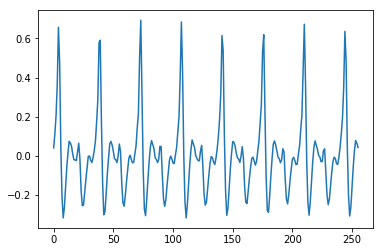

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
#foosig=instrument[1].getItem(220, 256)
foosig=instrument[0].getSource(k_lowNoteNum + int((k_highNoteNum-k_lowNoteNum)/2))
plt.plot(foosig[0:256])

### Reality check : plot an instrument 1 note 

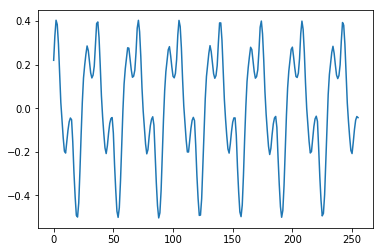

In [6]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

foosig=instrument[1].getSource(k_lowNoteNum + int((k_highNoteNum-k_lowNoteNum)/2))
plt.plot(foosig[0:256])

## Set up "augmented" input for pitch, volume, and instrument number

In [7]:
# conditioning parameters (aka controllers)
k_numControllers=3
#indices
k_pitch=0
k_volume=1
k_instNum=2

controller=[None]*k_numControllers
controller[k_pitch]=condparam(params['pitchParamType'], params['numPitchNodes'], params['seq_len'], 0, dtype)
controller[k_volume]=condparam(params['volumeParamType'], params['numVolumeNodes'], params['seq_len'], 0, dtype)
controller[k_instNum]=condparam(params['instParamType'], params['numInstNodes'], params['seq_len'], 0, dtype)

k_controllerNodeCount=0
for i in range(k_numControllers) :
    k_controllerNodeCount+=controller[i].numNodes
    
print('controller node count is ' + str(k_controllerNodeCount))

def setControllers(pvals, slen=params['seq_len'], verbose=False) :
    '''Pass in a list of values for the *all* the parameters (in their indexed order)
    Return a tensor of the parameter vectors concatenated together with their values set
    '''
    return torch.cat([controller[i].setTensor(pvals[i], slen, verbose=verbose) for i in range(len(pvals))],1)


controller node count is 4


## Data Readers

In [8]:

#returns inp tensor, and target mutable indexes (the "categegory" of the NEXT sample)
def get_training_example(instparam, cps, amp=1, phase=None, noiseamp=0, slen=params['seq_len']):

    rarray = amp * instrument[instparam].getItem(cps, slen+1, initphase=phase)
        
    if noiseamp != 0 :
        narray = noiseamp * np.random.uniform(low=-1, high=1, size=(slen))
    else :
        narray = np.zeros(slen)  
    inp    = torch.from_numpy(audiocoding.encode(rarray[:-1] + narray)).type(dtype) 
    
    #print("in get training example, encoded is " + str(inp))
    
    target = torch.from_numpy(targetcoding.float2index(rarray[1:])).type(ttype)
    return inp, target

def get_training_set(bs, verbose=False) :
    '''
    Returns 3 Variables: the audio input, the conditioning parameters, and the target
    '''
    stensor = torch.zeros(params['seq_len'], bs, k_inputVectLength).type(dtype)
    ttensor = torch.zeros(params['seq_len'], bs).type(ttype)
    condtensor = torch.zeros(params['seq_len'], bs, k_controllerNodeCount).type(dtype)#$$$ total length of all controller
    
    for b in range(bs) :
        #PITCH
        #remember, randint *excludes* high end val!
        condparamInt=np.random.randint(params['numPitchTrainVals']) # all N pitches are valid  (eg, [0,9] for 10 pitches) - 
        condparam=condparamInt/(params['numPitchTrainVals']-1) # [0,9]/9 to get float in [0,1]        
        cps=trainvals.param2freq(condparamInt)
        if verbose :
            print('----')
            print("condparam normed = " + str(condparam))
            print("condparam int (the nth of) = " + str(condparamInt))
            print("cps = " + str(cps))
        
        #VOLUME
        volumeparamInt=np.random.randint(params['numVolumeTrainVals'])
        volumeparam=volumeparamInt/(params['numVolumeTrainVals']-1)
        if verbose :
            print('----')
            print("volumeparam = " + str(volumeparam))
            print("volumeparamInt (the nth of ) = " + str(volumeparamInt))
        
        #INST
        instparam=int(np.random.randint(numInstruments)) #randin is exclusive of high value, so this works even for one instrument
            
        #get single example - note we scale the signal and noise by the same volume parameter
        stensor[:,b,:], ttensor[:,b] = get_training_example(instparam, cps, amp=volumeparam*sigAmp, \
                                                            noiseamp=volumeparam*trainingNoiseAmp, slen=params['seq_len'])
        
        condtensor[:,b,:] = setControllers([condparam, volumeparam, instparam], params['seq_len'],verbose)
        
    #print("returning training set of size s = " + str(stensor.size()) + ", and t = size  " + str(ttensor.size()))
    return Variable(stensor), Variable(condtensor), Variable(ttensor)


def get_prime_set(slen, pvals, primeWith="signal", verbose=False) : 
    '''condparam is in [0,1]
    primeWith - in ["noise", "zeros", "signal", "nearestNote"], nearestNote resolves to nearest midiNote number
    Returns 2 PyTorch Variables (the audio and the parameters) and a float array of the audio
    '''
    
    condparam=pvals[0]
    volumeparam=pvals[1]
    # For priming (not generation), must choose closest instrument used for training
    intinstparam=int(round(pvals[2]))
    
    bs=1
    stensor = torch.zeros(slen, bs, k_inputVectLength).type(dtype)
    condtensor = torch.zeros(slen, bs,  k_controllerNodeCount).type(dtype)
    farray=np.zeros((slen,bs)) # signals in columns 
    
    if (params['pitchParamType']==0) :  #conditioning parameter vector is a single real value
        cps=paramvals.param2freq(condparam) 
    else:
        cps=paramvals.param2freq(condparam*(params['numPitchNodes']-1)) #arg will be in [0,params['numPitchNodes']) - half open
    
    if verbose :
        print("cps = " + str(cps))
        
    for b in range(bs) :
        #For testing with different priming sequences
        if primeWith == "noise" : # "zeros", "signal"
            fseq=np.random.uniform(-1,1,slen)
        elif primeWith == "zeros" :
            fseq=np.zeros(slen)
        elif primeWith == "signal" :
            fseq = volumeparam*sigAmp*instrument[intinstparam].getItem(cps, slen)
        elif primeWith == "nearestNote" :
            tunedcps=midi.param2freq(np.round(midi.freq2param(cps)))
            fseq = volumeparam*sigAmp*instrument[intinstparam].getItem(tunedcps, slen)       
        elif True :
            assert(False)

        stensor[:,b,:] = torch.from_numpy(audiocoding.encode(fseq))
        
        #print("in get_prime_set, encoded is " + str(stensor))

        condtensor[:,b,:] = setControllers(pvals,slen, verbose)
        farray[:,b]=fseq
    return Variable(stensor), Variable(condtensor), farray #Variable(ftensor)


In [9]:

def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")



# Basic RNN Model 


The input is concatenated with the conditioning vector, <br>
fed into a fully connected layer mapping to a "hidden_size" vector which is <br>
fed into the GRU. <br>
<br>
Four GRU layers later, the output is fed through a linear layer to map it to the 256-length one-hot output vector.
</div>
<div style="width:25%; margin-left:auto; margin-right:auto; margin-bottom:5px; margin-top:17px;">
    <img src="img/architecture2_color.png" alt>
</div>



In [10]:

class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, cv, bs, hidden):
        #print("input size is " + str((input.size())))
        #print("cv size is " + str((cv.size())))
        input_combined = torch.cat((input, cv), 1)  #concatenate the input and conditioning vectors along the representation dimension
        
        h1 = self.i2h(input_combined)
        #print("size of h1 is " + str(h1.size()))
        
        output, hidden = self.gru(h1.view(1, bs, -1), hidden)
        #print("now decode")
        output = self.decoder(output.view(bs, -1))
        #print("done decoding")
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self, bs):
        return Variable(torch.zeros(self.n_layers, bs, self.hidden_size).type(dtype))


In [11]:
nth=np.zeros(100)   #keep track of the choice of n, the nth-best choice from the ordered list
storecount=0

# param is a "termperature" that controls how much randomness to use for choosing 
# (in [.45, 1]) - CUDA runs fail on numbers less than .45 (underflow?)
def chooseTemp(vect, param) :
    global storecount
    
    #output is tensor of size =[bs, quant]
    output_dist = vect.div(param).exp()  #if param is < .4 or so, output_dist will contain some Infs
    
    ### TESTING  vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    vals, inds = output_dist.sort(descending=True)
    
    #print("inds = " + str(inds))
    # Sample from the network as a multinomial distribution
    choice = torch.multinomial(output_dist, 1)
    
    if (storecount < 100) :
        nth[storecount]=1+(inds == choice).nonzero()[0,1]
        storecount=storecount+1
    
    ### TESTING  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
    return torch.multinomial(output_dist, 1) #returns index


sm=nn.Softmax()

# choose the top param number of of most strongly activated outputs
def choose(vect, param) :
    global storecount
    
    #print("vect size is " + str(vect.shape))
    foovalues, fooindices = vect.topk(param,1) #(k, dim)
    #print("foovalues size is " + str(foovalues.shape))
    baz=sm(Variable(foovalues))
    #print("baz size is " + str(baz.data.shape))
    barpick=torch.multinomial(baz.data, 1)
    #print("barpick is " + str(barpick))
    
     ### TESTING  vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    vals, inds = baz.data.sort(descending=True)
    
    #print("inds = " + str(inds))
    # Sample from the network as a multinomial distribution
    choice = barpick
    
    if (storecount < 100) :
        nth[storecount]=1+(inds == choice).nonzero()[0,1]
        storecount=storecount+1
    
    ### TESTING  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
    
    return fooindices[:,barpick[0]]

# Evaluating

To evaluate the network we will feed one sample at a time, use the outputs of the network as a probability distribution for the next character, and repeat. 

In [12]:

#pvals is either an array param values, or a function of sample number that returns an array of parameter values
def evaluate(predict_len, pvalfunc, temperature=0.8, primeWith="signal", verbose=False, saveSoftMax=False):

    if saveSoftMax :
        smax=np.zeros((params['q_levels'],predict_len))
    
    bs=1
    hidden = decoder.init_hidden(bs) 
        
    # the encoded input and UNencoded floats of slen that we'll use to seed the predicted sequence
    prime_input, condInput, predicted = get_prime_set(k_primeLen, pvalfunc(0), primeWith=primeWith, verbose=verbose)
    
    # torch.Size([seq_len, batchsize=1, n]
    ###print("prime_input shape is " + str(prime_input.size()))
    
    #print("Predicted with PRIME only = " + str(predicted))

    # Use priming string to "build up" hidden state
    for p in range(len(prime_input) - 1) :
        _, hidden = decoder(prime_input[p], condInput[p], bs, hidden)
        

    inp = prime_input[-1]  #last sample in seed provided
    

    
    for p in range(predict_len):
        paramvect=Variable(setControllers(pvalfunc(p),1))
        
        ###print("inp shape is " + str(inp.size()))
            
        output, hidden = decoder(inp, paramvect, bs, hidden)
        
        if saveSoftMax : 
            #print("smax shape: " + str(smax.shape))
            #print("output shape: " + str((output.data[0].cpu().numpy()).shape))
            smax[:,p]=output.data[0]#.cpu().numpy()
        
        #print("top_i shape is = " + str(top_i.shape))  
        if topN :
            top_i = choose(output.data, temperature)
        else :
            top_i = chooseTemp(output.data, temperature)
        
        # Add predicted character to string and use as next input
        if (params['cuda']) : 
            try :
                predicted_samp = targetcoding.index2float(top_i)# transpose to put batches in columns
            except : 
                print("output.data")
                print(str(output.data))
                print("top_i")
                print(str(top_i))
        else : 
            predicted_samp = targetcoding.index2float(top_i.numpy())# transpose to put batches in columns

        predicted_samp=predicted_samp[0]
        #predicted=np.append(predicted, predicted_samp.transpose(), axis=0)
        predicted=np.append(predicted, np.array([predicted_samp]).transpose(), axis=0)

        
        #print("predicted so far is " + str(predicted))
        
        ###print("predicted sample is " + str(predicted_samp))
        
                
        encoded=audiocoding.encode(predicted_samp)
        ###print("encoded is " + str(encoded))

        ###print("torch from numpy : " + str(torch.from_numpy(audiocoding.encode(predicted_samp)).type(dtype)))
        ###print("torch from numpy size = " + str(torch.from_numpy(audiocoding.encode(predicted_samp)).type(dtype).size()))
        ###print("Variable size = " + str((Variable(torch.from_numpy(audiocoding.encode(predicted_samp)).type(dtype))).size()))

        inp = Variable(torch.from_numpy(audiocoding.encode(predicted_samp)).type(dtype))  

        # want shape torch.Size([1, n])
        ###print("feedback inp shape is " + str(inp.size()))
        
        
    if saveSoftMax :
        outfilename=k_rootoutname +"softmax" + ".data"
        np.save(outfilename, smax)
        print("saved softmax data to " + outfilename)
        
    return predicted

In [14]:
def train(inp, cond, target):
    #using global variables we haven't even defined yet!
    hidden = decoder.init_hidden(params['batch_size'])
    decoder.zero_grad()
    loss = 0

    #chunk is a single input training string
    for c in range(params['seq_len']):
        #print("size of inp[c] is " + str(inp[c].size()))
        output, hidden = decoder(inp[c], cond[c], params['batch_size'], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / params['seq_len']

# Run the training epochs

Do it!
 55s (100 10%) 4.5417]


/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


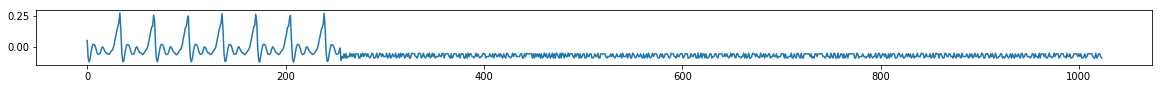

 51s (200 20%) 4.0884]


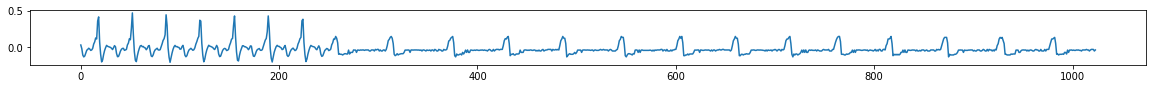

 48s (300 30%) 3.5868]


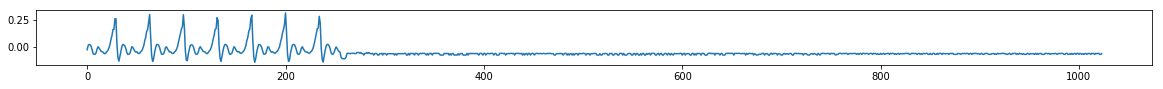

 44s (400 40%) 4.0885]


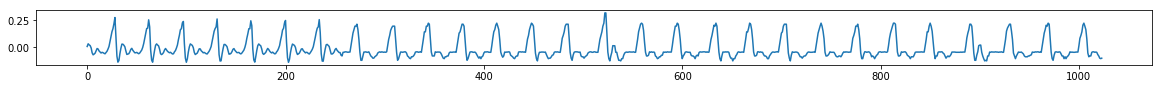

 41s (500 50%) 3.6028]


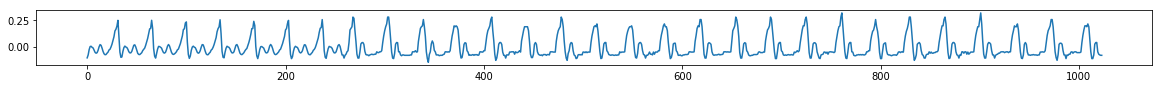

 37s (600 60%) 3.6782]


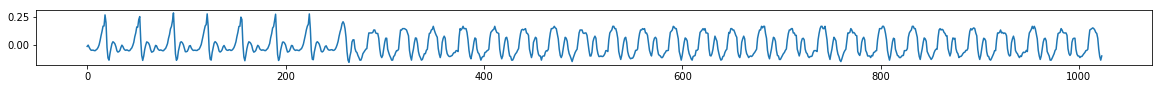

 34s (700 70%) 3.6392]


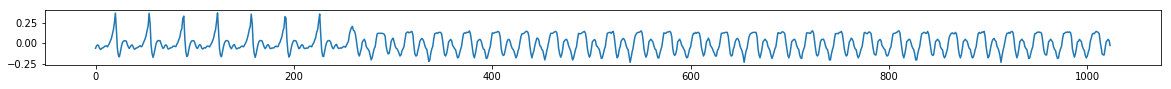

 30s (800 80%) 3.7594]


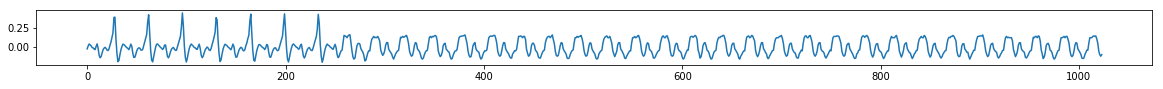

 27s (900 90%) 3.3909]


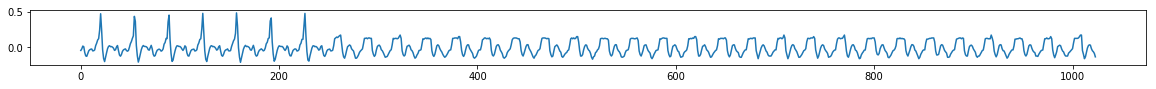

 23s (1000 100%) 3.1086]


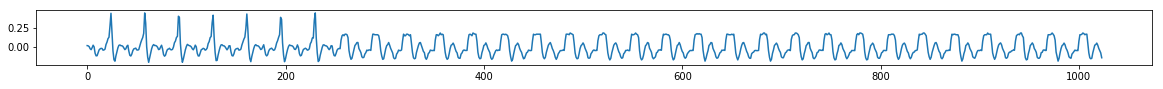

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

n_epochs =   params['epoch_limit']
print_every =  n_epochs/10
plot_every = 20
lr = k_lr


decoder = RNN(k_inputVectLength, k_controllerNodeCount, params['hidden_dim'], params['q_levels'], params['num_layers'])
if (params['cuda']) :
    decoder = decoder.cuda()

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

#[pitch, volume, instrument]
evalpvals=[.5,.75,.5]


#-------------------------------------------------------------------------
# https://blog.floydhub.com/checkpointing-tutorial-for-tensorflow-keras-and-pytorch/
if (False) :
    loss_avg = 0
    if cuda:
        checkpoint = torch.load(resume_weights)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(resume_weights,
                                map_location=lambda storage,
                                loc: storage)
    start_epoch = checkpoint['epoch']
    best_accuracy = checkpoint['best_accuracy']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
#-------------------------------------------------------------------------





if runTrain : 
    print("Do it!")
    for epoch in range(1, n_epochs + 1):
        loss = train(*get_training_set(params['batch_size'])) # *list unpacks the list      
        loss_avg += loss

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            result=evaluate(k_spewlen, lambda n: evalpvals, chooseTemperature, primeWith=k_trainPrimeSignal) #choose a middle value of the param for evaluation
            #print(result, '\n')
            #print("shape of result is " + str(result.shape))
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result[:,0]) #just print one example from the batch
            plt.show()


        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            
#-------------------------------------------------------------------------
# https://blog.floydhub.com/checkpointing-tutorial-for-tensorflow-keras-and-pytorch/
            if (False) :
                is_best = bool(loss_avg < best_loss_avg)
                # Get greater Tensor to keep track best acc
                best_loss = min(loss_avg, best_loss_avg)
                # Save checkpoint if is a new best
                save_checkpoint({
                    'epoch': start_epoch + epoch + 1,
                    'state_dict': decoder.state_dict(),
                    'best_accuracy': best_loss
                }, is_best, k_outpath +  "/"  +  checkpoint.pth.tar)
#-------------------------------------------------------------------------            
            
            loss_avg = 0

    

<img src="./img/border.png",  width="50%">

# <center><font color='maroon'>OK, Let's visualize!</font></center>

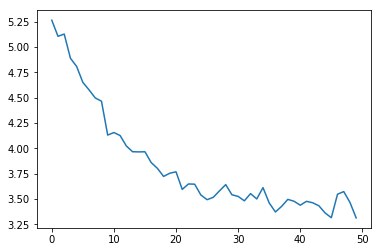

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

#### a couple of wave forms

cps = 329.627556913
Condtensor type = 0. Assign floatval = 0.0 to condindex 0 in vect with  1 nodes
Condtensor type = 0. Assign floatval = 1 to condindex 0 in vect with  1 nodes
Condtensor type = 2. Assign floatval = 1 to condindex 1 in vect with  2 nodes


/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


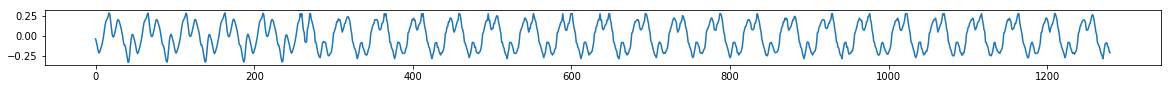

cps = 659.255113826
Condtensor type = 0. Assign floatval = 1.0 to condindex 0 in vect with  1 nodes
Condtensor type = 0. Assign floatval = 1 to condindex 0 in vect with  1 nodes
Condtensor type = 2. Assign floatval = 1 to condindex 1 in vect with  2 nodes


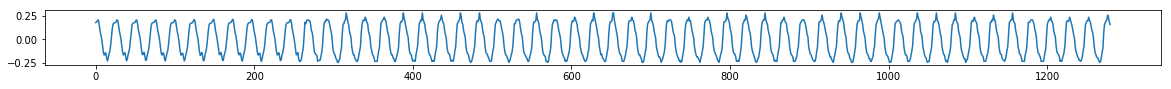

In [17]:
evalpvals=[midi.param2norm(k_lowNoteNum+0),1,1]
result=evaluate(1024, lambda n: evalpvals, temperature=chooseTemperature, primeWith=k_primeSignal,verbose=True)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(result)), result[:,0]) #just print one example from the batch
plt.show()

evalpvals=[midi.param2norm(k_lowNoteNum+12),1,1]
result=evaluate(1024, lambda n: evalpvals, temperature=chooseTemperature, primeWith=k_primeSignal,verbose=True)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(result)), result[:,0]) #just print one example from the batch
plt.show()
        

In [21]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import FloatSlider
%matplotlib inline

#

def showSnr(sig, freq, octavespan=3) : #span above and below # lowfspan=100, hifspan=100) 
    
    mffts=np.absolute(np.fft.fft(sig))
    freqs= np.fft.fftfreq(len(sig), 1/params['sample_rate'])
    
    #Compute bin numbers for spectrogram display
    sl=len(sig)
    freqbin= int(np.round(freq*sl/params['sample_rate']))
    lowf=freq*np.power(2.,-octavespan)
    lowbin=int(np.round(max(0, lowf*sl/params['sample_rate'])))
    hif=freq*np.power(2.,octavespan)
    hibin=int(np.round(min(sl/2 ,hif*sl/params['sample_rate'])))
    
    print("showSNR f = " + str(freq) + ", binnumber = " + str(freqbin))
    print("showSNR lowf = " + str(lowf) + ", binnumber = " + str(lowbin))
    print("showSNR hif = " + str(hif) + ", binnumber = " + str(hibin))
    
    plt.show()
    plt.plot(freqs[lowbin:hibin], mffts[lowbin:hibin])
    #plt.plot(mffts[:1500])
    
    total = np.sum(mffts[0:int(len(mffts)/2)])
    snr_freq= mffts[freqbin]/total
    maxbin=np.argmax(mffts[0:int(len(mffts)/2)])
    snr_max=mffts[maxbin]/total
    print('center freq (' + str(freq) + "), bin " + str(freqbin)+  "=" + str(float("{0:.6f}".format(snr_freq))) + ", and at max freq  (" + str(freqs[maxbin]) + "), bin " + str(maxbin) +  "=" + str(float("{0:.6f}".format(snr_max))))
     
    #return the snr for the requested bin
    return mffts[freqbin]/total



### <font color="brown"> Interact</font>

In [22]:
from ipywidgets import interactive

plt.show()

def widgetfunc(x,y, z):
    
    result=evaluate(int(params['sample_rate']/40), lambda n: [x, y, z], temperature=chooseTemperature, \
                    primeWith="nearestNote", verbose=True)
    plt.figure(figsize=(20,1)) 
    #note that the result includes the priming signal which also extends the length
    plt.plot(np.arange(len(result[k_primeLen:, 0])), result[k_primeLen:, 0]) #just print one example from the batch
    gplot=plt
    
xslider=FloatSlider(min=0, max=1, step=.01, value=0.0, continuous_update=False)
yslider=FloatSlider(min=0, max=1, step=.01, value=1.0, continuous_update=False)
zslider=FloatSlider(min=0, max=1, step=.01, value=0.0,  continuous_update=False)
w = interactive(widgetfunc, x=xslider, y=yslider, z=zslider)
display(w)

# x - pitch
# y - volume
# z - instrument

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=1.0, step=0.01), FloatSlider(value=1.0, continuous_update=False, description='y', max=1.0, step=0.01), FloatSlider(value=0.0, continuous_update=False, description='z', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

cps = 492.743505781
Condtensor type = 0. Assign floatval = 0.58 to condindex 0 in vect with  1 nodes
Condtensor type = 0. Assign floatval = 0.82 to condindex 0 in vect with  1 nodes
Condtensor type = 2. Assign floatval = 0.63 to condindex 0.63 in vect with  2 nodes


/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


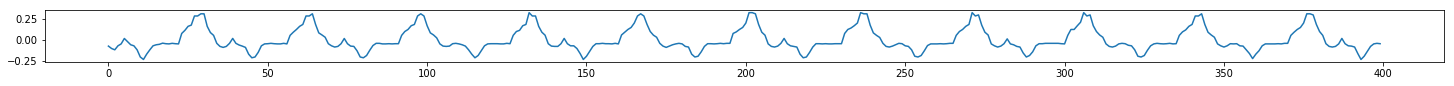

In [23]:
# Run this cell to save the last interact plot (from the previous cell) to file
# we have to generate the plot again since it seems impossible to "save" plots across cells
widgetfunc(xslider.value,yslider.value,zslider.value)
plt.tight_layout(pad=0)
plt.savefig(k_outpath  +"/" + mydate() + "_interactSignal2" + "_p" + \
            str(xslider.value) + "_v" + str(yslider.value) + "_i" + str(zslider.value) + ".png")

### <font color="brown"> Generate the Big Fig, with sig and spectra at various frequencies</font>

*** Evaluate for param = 64, freq = 329.627556913, volume 0.75, instn 0


/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


*** Evaluate for param = 66, freq = 369.994422712, volume 0.75, instn 0
*** Evaluate for param = 68, freq = 415.30469758, volume 0.75, instn 0
*** Evaluate for param = 69, freq = 440.0, volume 0.75, instn 0
*** Evaluate for param = 71, freq = 493.883301256, volume 0.75, instn 0
*** Evaluate for param = 73, freq = 554.365261954, volume 0.75, instn 0
*** Evaluate for param = 75, freq = 622.253967444, volume 0.75, instn 0
*** Evaluate for param = 76, freq = 659.255113826, volume 0.75, instn 0


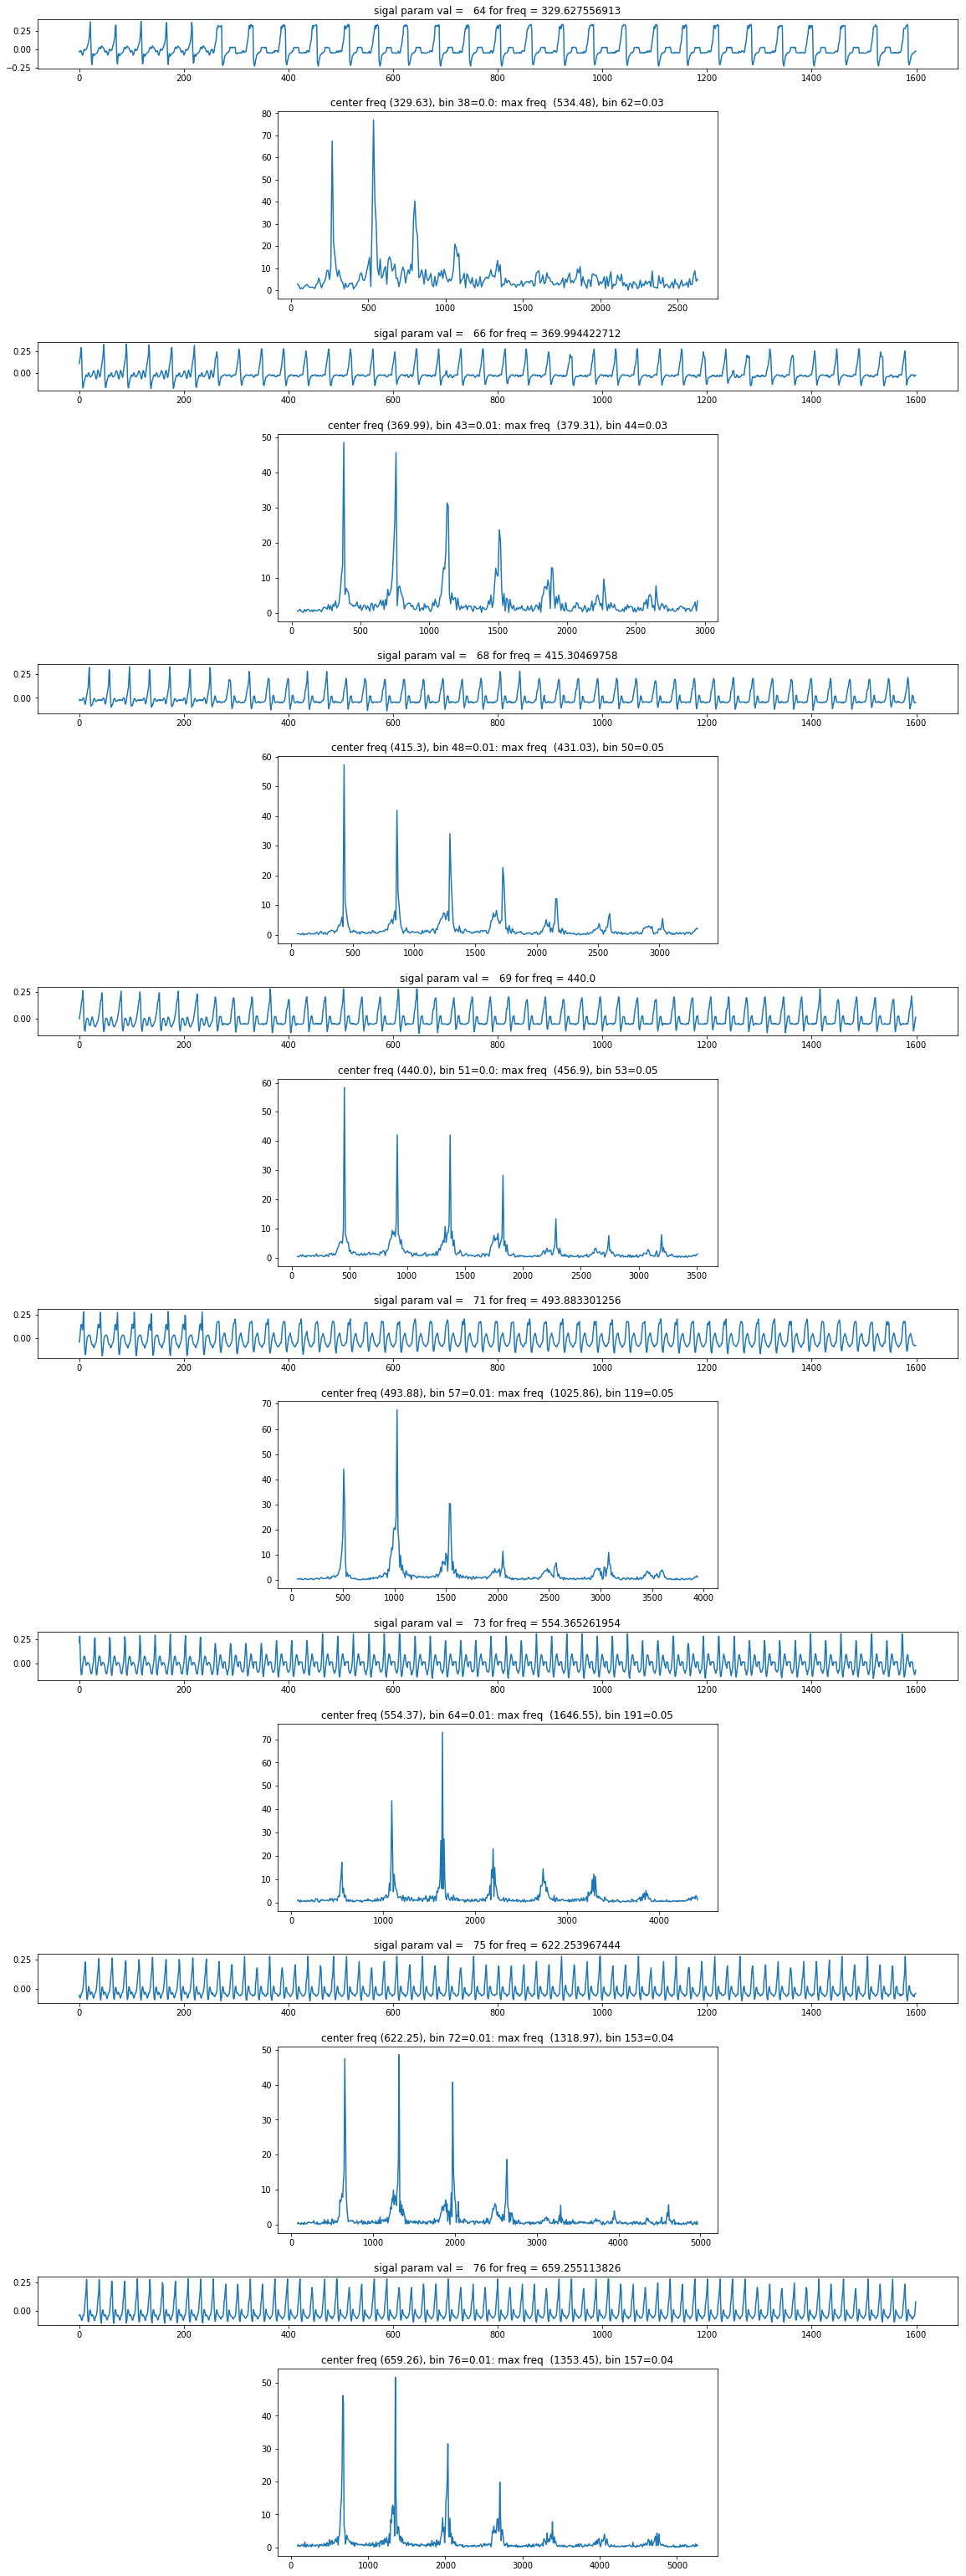

In [24]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec

beg=0   # sample numbers for plotting signal
end=1600

genlen=int(params['sample_rate']/10)

octavespan=3 #width to display on spectrogram around center frequency


gvals = np.array([0, 2,4,5,7,9,11,12])+k_lowNoteNum
#pvals = [0, .5, 1]
#gvals = np.array([5])+k_lowNoteNum
a=[None]*2*len(gvals) #list for holding subplots (for possible individual access later)
sigrspan=2
sigcspan=4
spectrspan=5
spectcspan=2

pairrows = sigrspan+spectrspan

numPlotPairs=len(gvals)
gridrows = numPlotPairs*(spectrspan+sigrspan+2)
gridcols=6

fig = plt.figure(figsize=(5*gridcols, gridrows))  #(width, height) in inches (say the docs)!
fig.subplots_adjust(hspace=15)

gridspec.GridSpec(gridrows,gridcols)

vol=.75
instn=0

i=0
j=0
for gval in gvals :
    freq = midi.param2freq(gval)
    normedf=midi.param2norm(gval)
    
    print("*** Evaluate for param = " + str(gval) + ", freq = " + str(freq) + ", volume " + \
          str(vol) + ", instn " + str(instn))
    sig=evaluate(genlen, lambda n: [normedf, vol, instn], temperature=chooseTemperature,\
                 primeWith=k_primeSignal,verbose=False)[:, 0]#[k_primeLen:, 0]

    #save wave file
    outfilename=k_rootoutname +"bigfig_snd." + str(gval)
    librosa.output.write_wav(outfilename +".wav", sig, params['sample_rate'])
    
    #plot signal tempRunOutDir
    rowspan=2
    colspan=2
    a[i]=plt.subplot2grid((gridrows,gridcols), (j*pairrows,0), colspan=sigcspan, rowspan=sigrspan)
    a[i].plot(sig[beg:end])
    a[i].set_title('sigal param val =   ' + str(gval) + " for freq = " + str(freq))
    
    #save waveform image
    outfilename=outfilename+"_temporal"
    extent = a[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(outfilename + ".png", bbox_inches=extent.padded(.4))
    
 
    
    #plot transform
    rowspan=3
    colspan=1
    
    mffts=np.absolute(np.fft.fft(sig))
    freqs= np.fft.fftfreq(len(sig), 1/params['sample_rate'])   # for labeling spectrum x-axis
    
    #Compute bin numbers for spectrogram display
    sl=len(sig)
    freqbin= int(np.round(freq*sl/params['sample_rate']))
    lowf=freq*np.power(2.,-octavespan)
    lowbin=int(np.round(max(0, lowf*sl/params['sample_rate'])))
    hif=freq*np.power(2.,octavespan)
    hibin=int(np.round(min(sl/2 ,hif*sl/params['sample_rate'])))
        
     
    total = np.sum(mffts[0:int(len(mffts)/2)])
    snr_freq= mffts[freqbin]/total
    maxbin=np.argmax(mffts[0:int(len(mffts)/2)])
    snr_max=mffts[maxbin]/total
           
    i=i+1
    a[i]=plt.subplot2grid((gridrows,gridcols), (j*pairrows+sigrspan,1), colspan=spectcspan, rowspan=spectrspan)
    a[i].plot(freqs[lowbin:hibin], mffts[lowbin:hibin])
    a[i].set_title('center freq (' + str(float("{0:.2f}".format(freq))) + \
                   "), bin " + str(freqbin)+  "=" + str(float("{0:.2f}".format(snr_freq))) + \
                   ": max freq  (" + str(float("{0:.2f}".format(freqs[maxbin]))) + \
                   "), bin " + str(maxbin) +  "=" + str(float("{0:.2f}".format(snr_max))))
    
    #save spectral image
    outfilename=outfilename+"_spectral"
    extent = a[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(outfilename + ".png", bbox_inches=extent.padded(.4))

    
    
    i=i+1
    j=j+1

#save the BIG FIG
plt.savefig(k_rootoutname + "BIGFIG" + str(zslider.value) + ".png")

### <font color="brown"> Listen</font>

In [25]:
#Wanna hear any of those?
normedf=7+k_lowNoteNum
wavfilename=  k_rootoutname +"bigfig_snd." + str(normedf)+".wav"
print(wavfilename)

x, sr = librosa.load(wavfilename, sr=None)
display(Audio(x, rate=params['sample_rate'], autoplay=True))

tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_bigfig_snd.71.wav


#### Save Big Fig subplots individually

In [28]:
# Save the "sub figures" individually, too. They are numbered in the order they are created, and the 
# labels are already on figures. Even numbered are wavs, odd numbered are spectral
for saveidx in range(2*len(gvals)) : #run this cell?
    #saveidx=1
    outfilename=k_rootoutname+"subfig" + str(saveidx)+".png"
    #print("saving to file " + outfilename)
    extent = a[saveidx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #print(extent)
    fig.savefig(outfilename, bbox_inches=extent.padded(.4))

print("saved subfigs to dir " + k_outpath)
#https://matplotlib.org/api/transformations.html#matplotlib.transforms.Bbox

saved subfigs to dir tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet


### <font color="brown"> Sweep Pitch</font>

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


output file name is tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_pitchsweep_i0trumpet
output file name is tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_pitchsweep_i0.5
output file name is tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_pitchsweep_i1clarinet


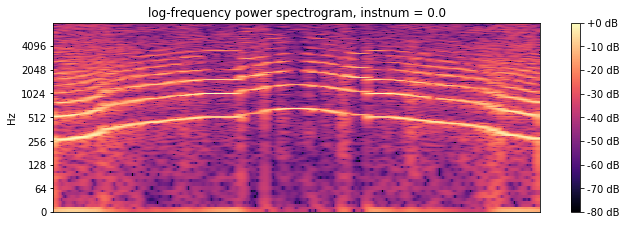

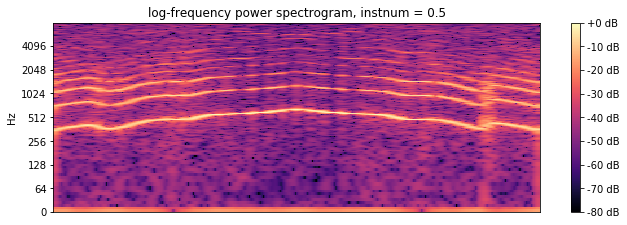

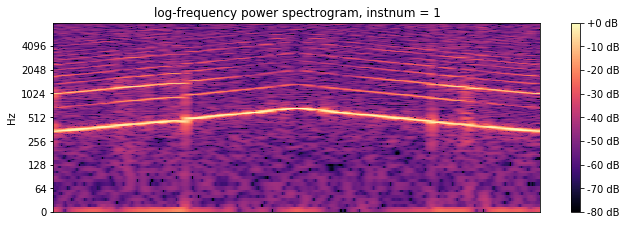

In [29]:
import librosa.display
genlen= int(3*params['sample_rate'])
instnums=[0., .5, 1]

def fsweep(snum) : 
    t=snum/genlen #snum/params['sample_rate']
    p=2*(.5-np.abs(.5-t))
    v=1
    i=instnum
    return [p,v,i]   

count=0
for instnum in instnums : 
    count = count+1
    result=evaluate(genlen, fsweep, chooseTemperature, primeWith=k_primeSignal) #choose a middle value of the param for evaluation

    y=result[k_primeLen:, 0]
    sr=params['sample_rate']
    plt.figure(figsize=(24, 16))
    D = librosa.amplitude_to_db(librosa.stft(y, hop_length=128), ref=np.max)
    plt.subplot(4, 2, count)
    librosa.display.specshow(D, y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('log-frequency power spectrogram, instnum = ' +str(instnum))


    #save wave file
    if (instnum) == 0 or (instnum == 1) :
        outfilename=k_rootoutname + "pitchsweep_i" +str(int(instnum))+ instrument[int(instnum)].name 
    else : 
        outfilename=k_rootoutname + "pitchsweep_i" +str(instnum) 

    print("output file name is " + outfilename)
    librosa.output.write_wav(outfilename + ".wav", y, params['sample_rate'])
    
    #outfilename=k_outpath+"/subfig" + str(saveidx)+".png"
    #print("saving to file " + outfilename)
    #extent = a[saveidx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #print(extent)
    #fig.savefig(outfilename +".png", bbox_inches=extent.padded(.4))
    plt.savefig(outfilename +".png")




In [30]:
# Listen to a sweeps (set instnum and run cell)
instnum=1
if (instnum) == 0 or (instnum == 1) :
    outfilename=k_rootoutname + "pitchsweep_i" +str(int(instnum))+ instrument[int(instnum)].name + ".wav"
else : 
    outfilename=k_rootoutname + "pitchsweep_i" +str(instnum) + ".wav"

print("file name is " + outfilename)
y,sr=librosa.core.load(outfilename, sr=None) 
display(Audio(y, rate=sr, autoplay=True))


file name is tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_pitchsweep_i1clarinet.wav


### <font color="brown"> Sweep Volume</font>

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


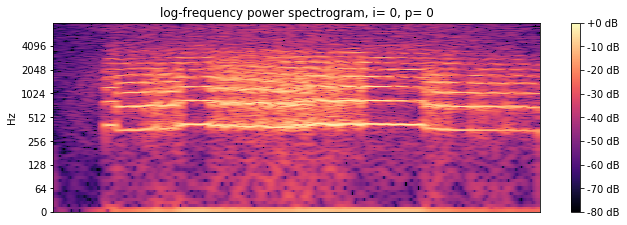

In [31]:
genlen= int(3*params['sample_rate'])
relPNum=0
iNum=0

def fsweep(snum) : 
    t=snum/genlen #t goes from 0 to 1 over the signal duration 
    v= .05 + 1*(.5-np.abs(.5-t))
    p=midi.param2norm(relPNum+k_lowNoteNum)
    i=iNum
    return [p,v,i]   

result=evaluate(genlen, fsweep, chooseTemperature, primeWith=k_primeSignal) #choose a middle value of the param for evaluation

y=result[k_primeLen:, 0]
sr=params['sample_rate']
plt.figure(figsize=(24, 16))
D = librosa.amplitude_to_db(librosa.stft(y, hop_length=128), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='log', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('log-frequency power spectrogram, i= ' + str(iNum) + ", p= " + str(relPNum))


#save wave file
outfilename=k_rootoutname+"volumeSweep" + "_iNum." + str(iNum) + "_pNum." + str(relPNum) 
librosa.output.write_wav(outfilename + ".wav", y, params['sample_rate'])
plt.savefig(outfilename +".png")

display(Audio(y, rate=params['sample_rate'], autoplay=False))

### <font color="brown"> Sweep Instrument</font>

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


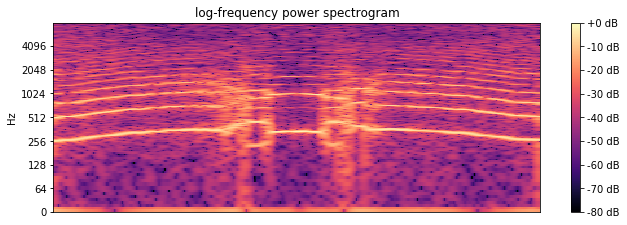

In [32]:
genlen= int(3*params['sample_rate'])
scaleNumber=0

def fsweep(snum) : 
    t=snum/genlen #snum/params['sample_rate']
    i=2*(.5-np.abs(.5-t))
    v=1
    p=midi.param2norm(scaleNumber+k_lowNoteNum)
    return [p,v,i]   

result=evaluate(genlen, fsweep, chooseTemperature, primeWith=k_primeSignal) #choose a middle value of the param for evaluation

y=result[k_primeLen:, 0]
sr=params['sample_rate']
plt.figure(figsize=(24, 16))
D = librosa.amplitude_to_db(librosa.stft(y, hop_length=128), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='log', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('log-frequency power spectrogram')


#save wave file
outfilename=k_rootoutname+"sndshape"
librosa.output.write_wav(outfilename+".wav", y, params['sample_rate'])
plt.savefig(outfilename +".png")

display(Audio(y, rate=params['sample_rate'], autoplay=False))

### <font color="brown"> Arpeggio Pitch</font>

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


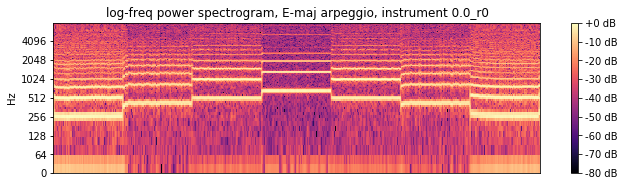

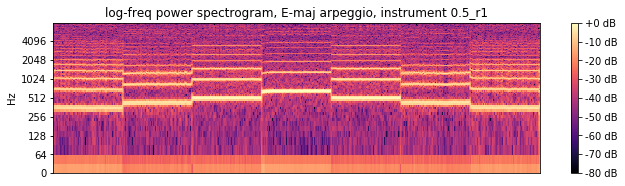

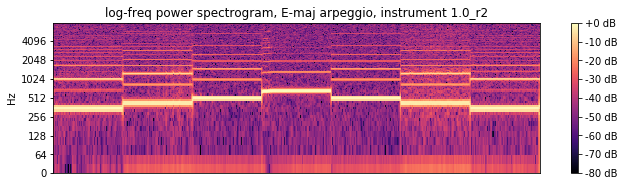

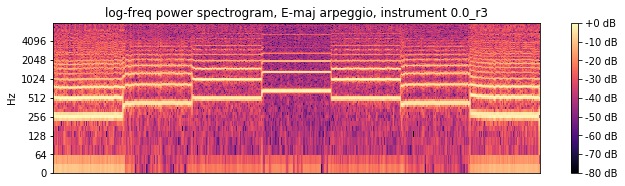

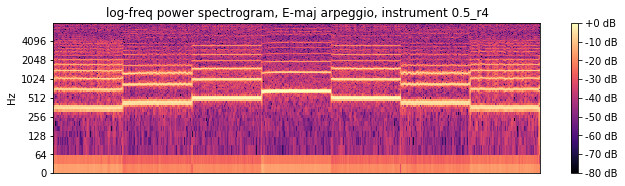

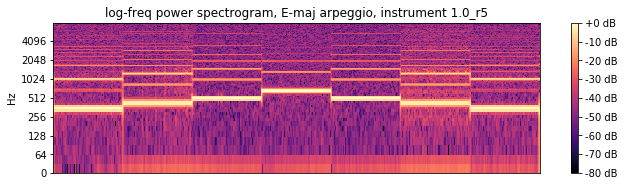

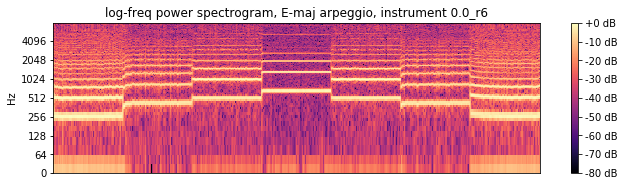

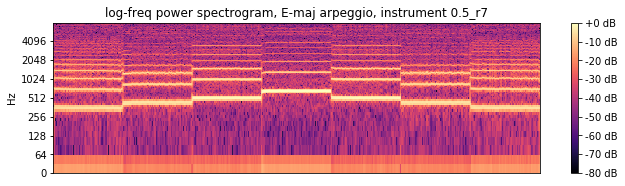

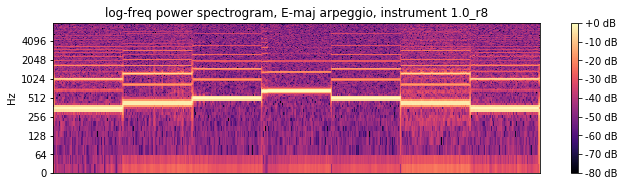

In [33]:
import librosa.display

genlen= int(5*params['sample_rate'])

notes=np.array([0,4,7,12,7,4,0])+k_lowNoteNum


instrument_list=[0.0,0.5,1.0, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0]
use_instrument_num=0

def f(snum) : 
    idx=int(len(notes)*snum/genlen) #snum/params['sample_rate']
    p=midi.param2norm(notes[idx])
    v=1
    i=use_instrument_num #global variable
    return [p,v,i]

y=[None]*len(instrument_list)

for i in range(len(instrument_list)) :
    use_instrument_num = instrument_list[i]
    result1=evaluate(genlen, f, chooseTemperature, primeWith=k_primeSignal) 

    y[i]=result1[k_primeLen:, 0]
    sr=params['sample_rate']
    plt.figure(figsize=(24, 16))
    D = librosa.amplitude_to_db(librosa.stft(y[i], n_fft=512, hop_length=128), ref=np.max)
    fooax=plt.subplot(5, 2, i+1)
    librosa.display.specshow(D, y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('log-freq power spectrogram, E-maj arpeggio, instrument ' + str(instrument_list[i]) + "_r"+ str(i)  )
    #save wave file
    outfilename=k_rootoutname + "arpeggio_" + str(i) + "_" + str(instrument_list[i])
    librosa.output.write_wav(outfilename  +"_.wav", y[i], params['sample_rate'])
    
        #save spectral image
    extent = fooax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(outfilename + ".png", bbox_inches=extent.padded(.4))


display(Audio(y[0], rate=params['sample_rate'], autoplay=False))

In [34]:
i=2
outfilename=k_rootoutname + "arpeggio_" + str(i) + "_" + str(instrument_list[i]) +"_.wav"
print("file name is " + outfilename)
y,sr=librosa.core.load(outfilename, sr=None) 
display(Audio(y, rate=sr, autoplay=True))
outfilename

file name is tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_arpeggio_2_1.0_.wav


'tempRunOut/ahot0_phot0_ptvals13_vhot0_vtvals13_iptype.2_i0.trumpet_i1.clarinet/2018.05.28_arpeggio_2_1.0_.wav'

### <font color="brown"> View tones</font>

**********************************************


/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


for note 64
showSNR f = 329.627556913, binnumber = 824
showSNR lowf = 164.813778456, binnumber = 412
showSNR hif = 659.255113826, binnumber = 1648


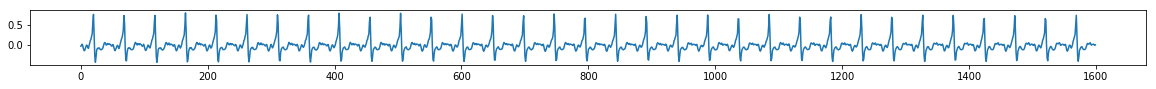

center freq (329.627556913), bin 824=0.008428, and at max freq  (659.2), bin 1648=0.018154
snr is 0.00842785186603


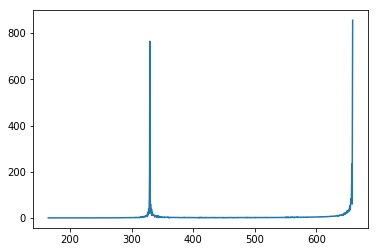

**********************************************
for note 76
showSNR f = 659.255113826, binnumber = 1648
showSNR lowf = 329.627556913, binnumber = 824
showSNR hif = 1318.51022765, binnumber = 3296


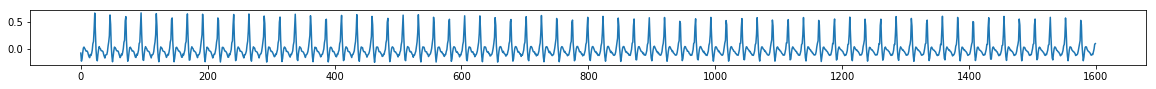

center freq (659.255113826), bin 1648=0.026736, and at max freq  (659.2), bin 1648=0.026736
snr is 0.0267356949131


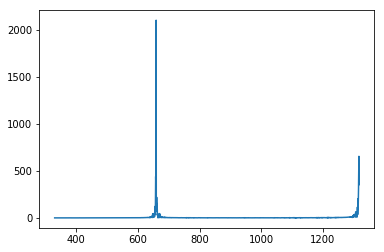

In [35]:
genlen=int(params['sample_rate']/10)

if True :
    beg=0
    end=genlen

    v=.75
    instn=0

    #for normedf in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9] :
    for normedf in [0, 1] :
        print('**********************************************' )
        s=evaluate(genlen, lambda n: [normedf, v, instn], temperature=chooseTemperature,primeWith="nearestNote", verbose=False)[k_primeLen:, 0]
        idx=int(np.round(midi.norm2param(normedf)))
        s=instrument[0].getSource(idx)
        print("for note " + str(idx))

        plt.figure(figsize=(20,1)) 
        plt.plot(s[beg:end])

        freq=trainvals.norm2freq(normedf)
        r=showSnr(s, freq, 1)
        print("snr is " + str(r))
        plt.show()

In [36]:
nth  #from early in training

array([ 1.,  1.,  3.,  2.,  3.,  1.,  3.,  2.,  2.,  3.,  1.,  2.,  1.,
        2.,  3.,  2.,  2.,  2.,  3.,  3.,  1.,  1.,  3.,  1.,  2.,  2.,
        1.,  2.,  1.,  3.,  2.,  3.,  2.,  3.,  3.,  2.,  3.,  3.,  1.,
        3.,  2.,  1.,  2.,  1.,  1.,  1.,  3.,  3.,  1.,  3.,  3.,  1.,
        1.,  1.,  1.,  3.,  3.,  1.,  1.,  3.,  3.,  1.,  2.,  2.,  3.,
        1.,  2.,  1.,  3.,  3.,  3.,  1.,  3.,  2.,  2.,  1.,  1.,  3.,
        1.,  3.,  2.,  3.,  1.,  3.,  1.,  3.,  2.,  1.,  1.,  3.,  3.,
        1.,  3.,  1.,  2.,  3.,  1.,  2.,  2.,  1.])

In [37]:
storecount=0
sig=evaluate(16000, lambda n: [midi.param2norm(5+k_lowNoteNum), 1, 0], temperature=chooseTemperature,\
             primeWith="nearestNote", verbose=False)[k_primeLen:, 0]

/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
nth #post training

array([ 2.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  2.,  3.,  2.,  2.,  2.,
        3.,  1.,  2.,  2.,  3.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,
        1.,  2.,  1.,  1.,  3.,  2.,  1.,  3.,  2.,  3.,  3.,  2.,  2.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  2.,  1.,  1.,  3.,
        2.,  1.,  1.,  3.,  2.,  3.,  2.,  1.,  2.,  1.,  2.,  3.,  1.,
        1.,  3.,  2.,  1.,  1.,  3.,  3.,  3.,  1.,  2.,  2.,  1.,  1.,
        3.,  3.,  1.,  3.,  1.,  3.,  1.,  3.,  1.,  2.,  2.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  3.])

### <font color="brown"> Generate Parameters for DIARY</font>

In [39]:
#print key parameters for Diary markdown

if (True) :
    print('<font size="2">')
    print('<table>')
    print('  <tr>')
    print('    <td>')
    print("<b>Parmeters:</b><br>")
    print('    </td>')
    print('  </tr>')

    print('  <tr>')
    print('    <td>')
    print('    <div class="alert alert-block alert-info">') 
    print('    <font size="1">') 
    #-----------------------------------------------------------------------------------

    print(' numInstruments = ' + str(numInstruments) + '                   <br>')
    print(' instrument[0].name = ' + instrument[0].name + '                   <br>')
    print(' instrument[1].name = ' + instrument[1].name + '                   <br>')
    print(' k_primeSignal = ' + k_primeSignal + '  # "zeros", "signal"                  <br>')
    print('<br>')
    print(' params[hidden_dim] = ' + str(params['hidden_dim']) + '                    <br>')
    print(' params[num_layers] = ' + str(params['num_layers']) + '                    <br>')
    print(' params[batch_size] = ' + str(params['batch_size']) + '                    <br>')
    print(' params[epoch_limit] = ' + str(params['epoch_limit']) + '                    <br>')
    print(' params[resume] = ' + str(params['resume']) + '                    <br>')

    #-----------------------------------------------------------------------------------
    print('    </font>') 
    print('    </div>') 
    print('    </td>')

    print('    <td>')
    print('    <div class="alert alert-block alert-info">') 
    print('    <font size="1">')   
    #-----------------------------------------------------------------------------------
    
    
    print(' params[q_levels] = ' + str(params['q_levels']) + '                    <br>')
    print(' params[seq_len] = ' + str(params['seq_len'])+ '                    <br>')
    print(' params[audioNHot] = ' + str(params['audioNHot']) + '                    <br>')

    print(' params[pitchParamType] = ' + str(params['pitchParamType']) + '                    <br>')
    print(' params[numPitchNodes] = ' + str(params['numPitchNodes']) + '                    <br>')
    print(' params[numPitchTrainVals] = ' + str(params['numPitchTrainVals']) + '                    <br>')

    print(' params[volumeParamType] = ' + str(params['volumeParamType']) + '                    <br>')
    print(' params[numVolumeNodes] = ' + str(params['numVolumeNodes']) + '                    <br>')
    print(' params[numVolumeTrainVals] = ' + str(params['numVolumeTrainVals']) + '                    <br>')

    print(' params[sample_rate] = ' + str(params['sample_rate']) + '                    <br>')
    #-----------------------------------------------------------------------------------
    print('    </font>') 
    print('    </div>') 
    print('    </td>')

    print('    <td>')
    print('    <div class="alert alert-block alert-info">') 
    print('    <font size="1">')
    #-----------------------------------------------------------------------------------
    print(' k_lr = ' + str(k_lr) + '                    <br>')
    print(' k_mincps = ' + str(k_mincps) + '                    <br>')
    print(' k_maxcps = ' + str(k_maxcps) + '                    <br>')
    print(' trainingNoiseAmp = ' + str(trainingNoiseAmp) + '                    <br>')
    print(' topN = ' + str(topN) + '                    <br>')
    print(' chooseTemperature = ' + str(chooseTemperature) + '                    <br>')

    #-----------------------------------------------------------------------------------
    print('    </font>') 
    print('    </div>') 
    print('    </td>')
    print('  </tr>')
    print('<table>')

<font size="2">
<table>
  <tr>
    <td>
<b>Parmeters:</b><br>
    </td>
  </tr>
  <tr>
    <td>
    <div class="alert alert-block alert-info">
    <font size="1">
 numInstruments = 2                   <br>
 instrument[0].name = trumpet                   <br>
 instrument[1].name = clarinet                   <br>
 k_primeSignal = signal  # "zeros", "signal"                  <br>
<br>
 params[hidden_dim] = 40                    <br>
 params[num_layers] = 4                    <br>
 params[batch_size] = 25                    <br>
 params[epoch_limit] = 1000                    <br>
 params[resume] = True                    <br>
    </font>
    </div>
    </td>
    <td>
    <div class="alert alert-block alert-info">
    <font size="1">
 params[q_levels] = 256                    <br>
 params[seq_len] = 256                    <br>
 params[audioNHot] = 0                    <br>
 params[pitchParamType] = 0                    <br>
 params[numPitchNodes] = 1                    <br>
 params[numPitch